# 1. Import libraries

In [1]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import joblib
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# Import models
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc

import scikitplot as skplt

# 2. Loading the Dataset

In [2]:
df = pd.read_csv('./ny_ready_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6958307 entries, 0 to 6958306
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ADDR_PCT_CD        float64
 1   CRIME_CLASS        int64  
 2   BORO_NM            int64  
 3   IN_PARK            int64  
 4   IN_PUBLIC_HOUSING  int64  
 5   Latitude           float64
 6   Longitude          float64
 7   IN_STATION         int64  
 8   VIC_AGE_GROUP      object 
 9   VIC_RACE           int64  
 10  VIC_SEX            int64  
 11  year               int64  
 12  month              int64  
 13  day                int64  
 14  hour               int64  
 15  weekday            object 
dtypes: float64(3), int64(11), object(2)
memory usage: 849.4+ MB


In [3]:
df.head()

,ADDR_PCT_CD,CRIME_CLASS,BORO_NM,IN_PARK,IN_PUBLIC_HOUSING,Latitude,Longitude,IN_STATION,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,year,month,day,hour,weekday
0,81.0,1,5,0,0,40.685041,-73.921777,0,25-44,7,4,2014,9,4,17,Thursday
1,121.0,2,4,0,0,40.636991,-74.134093,0,45-64,6,4,2016,10,12,7,Wednesday
2,41.0,2,3,0,0,40.823876,-73.891863,0,45-64,6,4,2012,9,28,13,Friday
3,46.0,1,3,0,0,40.845707,-73.910398,0,<18,6,4,2015,3,24,15,Tuesday
4,109.0,1,2,0,0,40.763992,-73.828426,0,25-44,5,3,2017,5,20,4,Saturday


In [4]:
df.shape

(6958307, 16)

In [5]:
df.CRIME_CLASS.value_counts().sort_values(ascending=False)

1    3925730
2    2140495
0     892082
Name: CRIME_CLASS, dtype: int64

C:\Users\rihab\AppData\Local\Temp\ipykernel_13864\3520224190.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


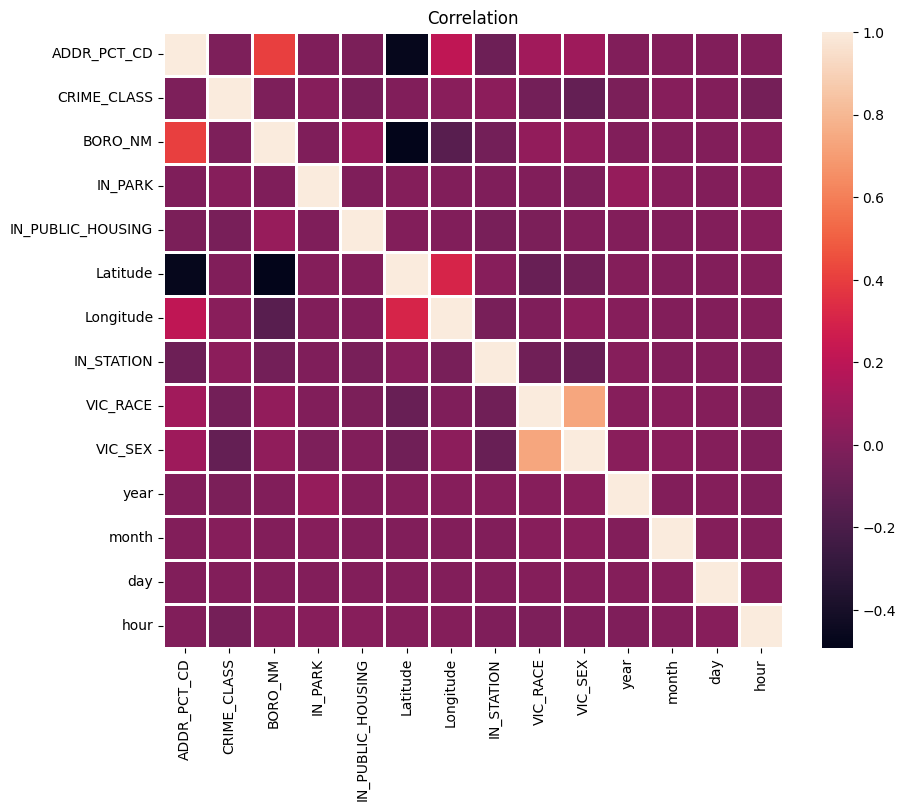

In [6]:
corr = df.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr, linewidth = 1, linecolor = "white")
plt.title("Correlation")
plt.show()

In [7]:
cols = ['ADDR_PCT_CD','BORO_NM']
df = df.drop(cols, axis=1)

# 3. Data preparing

## 3.1 Deal with categorical data

In [8]:
df_state_dummy = pd.get_dummies(df)

df_state_dummy.head()

,CRIME_CLASS,IN_PARK,IN_PUBLIC_HOUSING,Latitude,Longitude,IN_STATION,VIC_RACE,VIC_SEX,year,month,...,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18,VIC_AGE_GROUP_UNKNOWN,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,1,0,0,40.685041,-73.921777,0,7,4,2014,9,...,0,0,0,0,0,0,0,1,0,0
1,2,0,0,40.636991,-74.134093,0,6,4,2016,10,...,0,0,0,0,0,0,0,0,0,1
2,2,0,0,40.823876,-73.891863,0,6,4,2012,9,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,40.845707,-73.910398,0,6,4,2015,3,...,0,1,0,0,0,0,0,0,1,0
4,1,0,0,40.763992,-73.828426,0,5,3,2017,5,...,0,0,0,0,0,1,0,0,0,0


In [9]:
df_state_dummy.shape

(6958307, 25)

In [10]:
df_state_dummy = df_state_dummy.rename({'VIC_AGE_GROUP_<18':'VIC_AGE_GROUP_-18'},axis = 1)

In [11]:
df_state_dummy.head()

,CRIME_CLASS,IN_PARK,IN_PUBLIC_HOUSING,Latitude,Longitude,IN_STATION,VIC_RACE,VIC_SEX,year,month,...,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_-18,VIC_AGE_GROUP_UNKNOWN,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,1,0,0,40.685041,-73.921777,0,7,4,2014,9,...,0,0,0,0,0,0,0,1,0,0
1,2,0,0,40.636991,-74.134093,0,6,4,2016,10,...,0,0,0,0,0,0,0,0,0,1
2,2,0,0,40.823876,-73.891863,0,6,4,2012,9,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,40.845707,-73.910398,0,6,4,2015,3,...,0,1,0,0,0,0,0,0,1,0
4,1,0,0,40.763992,-73.828426,0,5,3,2017,5,...,0,0,0,0,0,1,0,0,0,0


## 3.2 Spliting the data into train and test

In [12]:
# Assign the data
df=df_state_dummy

# Set the target for the prediction
target='CRIME_CLASS'

# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

In [13]:
y.unique()
y.value_counts()

1    3925730
2    2140495
0     892082
Name: CRIME_CLASS, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=21, stratify=y)

In [15]:
X_train

,IN_PARK,IN_PUBLIC_HOUSING,Latitude,Longitude,IN_STATION,VIC_RACE,VIC_SEX,year,month,day,...,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_-18,VIC_AGE_GROUP_UNKNOWN,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
1163917,0,0,40.704336,-73.797706,0,0,3,2009,3,31,...,0,0,1,0,0,0,0,0,1,0
5447050,0,0,40.817356,-73.909331,0,3,4,2013,8,21,...,0,0,0,0,0,0,0,0,0,1
4522503,0,0,40.810058,-73.925145,0,0,1,2006,2,24,...,0,0,1,1,0,0,0,0,0,0
2071449,0,0,40.868467,-73.821583,0,0,1,2007,3,15,...,0,0,1,0,0,0,0,1,0,0
3037874,0,0,40.620771,-73.999782,0,7,4,2011,7,20,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177345,0,0,40.767767,-73.993265,0,0,1,2008,2,20,...,0,0,1,0,0,0,0,0,0,1
4331816,0,0,40.741769,-73.906178,0,0,1,2019,8,6,...,0,0,1,0,0,0,0,0,1,0
3711919,0,0,40.669485,-73.986051,0,7,4,2018,4,24,...,0,0,0,0,0,0,0,0,1,0
4566218,0,0,40.718452,-73.998753,0,0,1,2015,5,15,...,0,0,1,1,0,0,0,0,0,0


# 4. Utils

In [16]:
def report(y_test, y_pred, model):
    ac_sc = accuracy_score(y_test, y_pred)
    rc_sc = recall_score(y_test, y_pred ,average="weighted")
    pr_sc = precision_score(y_test, y_pred ,average="weighted")
    f1_sc = f1_score(y_test, y_pred, average='micro')

    print(("========== {} Results ==========").format(model))
    print("accuracy_score: {:.4f}.".format( ac_sc))
    print("Recall: {:.4f}.".format(rc_sc))
    print("Precision: {:.4f}.".format(pr_sc))
    print("F1 Score: {:.4f}.".format(f1_sc))

In [17]:
def plot_cm(y_pred,y_test,model,figure_name):
    mat_RF = confusion_matrix(y_pred,y_test)
    plt.figure(figsize=(8,4))
    sns.heatmap(mat_RF, square=True, annot=True, fmt='d', cbar=False,xticklabels=[0,1,2],yticklabels=[0,1,2],cmap = "coolwarm")
    plt.xlabel('True labels')
    plt.ylabel('predicted labels')
    plt.title(model)
    plt.savefig(figure_name)

In [18]:
def save_model(model, model_name,is_tree=False):
    joblib.dump(model.estimators_[0] if is_tree else model,f'{model_name}.joblib')
    print(f"Model size: {np.round(os.path.getsize(f'{model_name}.joblib') / 1024 / 1024, 2) } MB")

# 5. Modeling

## 5.1 Random forest

In [19]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100,n_jobs=-1,verbose=1)

#Train the model using the training sets
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  4.0min finished


In [20]:
report(y_test, y_pred, "Random Forest")

========== Random Forest Results ==========
accuracy_score: 0.5647.
Recall: 0.5647.
Precision: 0.5180.
F1 Score: 0.5647.


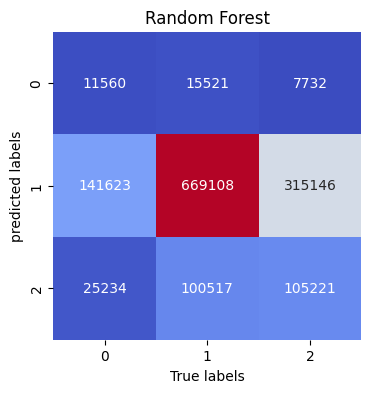

In [21]:
# Plot confusion matrix
plot_cm(y_pred,y_test,"Random Forest","cm_random_forest.pdf")

In [22]:
# Save model
save_model(clf,"random_forest",True)

Model size: 287.41 MB


## 5.2 LightGBM

In [28]:
# Define the model hyperparameters
lgbm_params = {
          "boosting_type": "gbdt",
          "learning_rate": 0.1,
          "num_leaves": 20,
          "max_bin": 256,
          "verbosity": 1,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9}
# Train the model
lbm_clf = lgbm.LGBMClassifier(**lgbm_params)
lbm_clf.fit(X_train,y_train)
# Evaluate the model
y_pred = clf.predict(X_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 5566645, number of used features: 24
[LightGBM] [Info] Start training from score -2.054134
[LightGBM] [Info] Start training from score -0.572384
[LightGBM] [Info] Start training from score -1.178899


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   58.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.1min finished


In [29]:
report(y_test, y_pred, "LightGBM")

========== LightGBM Results ==========
accuracy_score: 0.5647.
Recall: 0.5647.
Precision: 0.5180.
F1 Score: 0.5647.


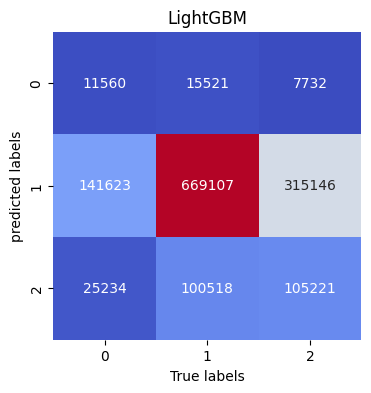

In [30]:
plot_cm(y_pred, y_test, "LightGBM", 'cm_LightGBM.pdf')

In [31]:
# Save the model
save_model(lbm_clf, "lightgbm")

Model size: 0.68 MB


## 5.3 XGBBoost

In [23]:
# Before training the model, we need to remove some special characters from the columns name
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [24]:
# Define the model hyperparameters
params = {
            'objective':'multi:softmax',
            'max_depth': 10,
            'alpha': 10,
            'learning_rate': 0.1,
            'n_estimators':100,
            'use_label_encoder':False
        }

# instantiate the classifier 
xgb_clf = XGBClassifier(**params)

# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

# test the models performace
y_pred = xgb_clf.predict(X_test)

c:\users\rihab\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [25]:
report(y_test, y_pred, "XGBBoost")

========== XGBBoost Results ==========
accuracy_score: 0.5771.
Recall: 0.5771.
Precision: 0.5439.
F1 Score: 0.5771.


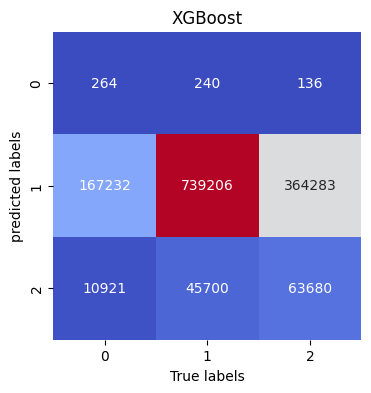

In [26]:
plot_cm(y_pred, y_test, "XGBoost", 'cm_XGBoost.pdf')

In [27]:
# Save the model
save_model(xgb_clf, "XGBoost")

Model size: 12.43 MB


## 5.4 MLPClassifier

In [32]:
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(100,), 
                         random_state=1,
                         max_iter=1000,
                         verbose=True
                        )

# Model Training
nn_model.fit(X=X_train,
             y=y_train)

# Prediction
y_pred = nn_model.predict(X_test) 

Iteration 1, loss = 1.27097226
Iteration 2, loss = 1.07930920
Iteration 3, loss = 1.00909413
Iteration 4, loss = 0.96275064
Iteration 5, loss = 0.93139520
Iteration 6, loss = 0.90715123
Iteration 7, loss = 0.90502995
Iteration 8, loss = 0.90404788
Iteration 9, loss = 0.90339922
Iteration 10, loss = 0.90308077
Iteration 11, loss = 0.90290380
Iteration 12, loss = 0.90285110
Iteration 13, loss = 0.90274996
Iteration 14, loss = 0.90267856
Iteration 15, loss = 0.90263432
Iteration 16, loss = 0.90265093
Iteration 17, loss = 0.90258458
Iteration 18, loss = 0.90252891
Iteration 19, loss = 0.90250477
Iteration 20, loss = 0.90252233
Iteration 21, loss = 0.90246014
Iteration 22, loss = 0.90249567
Iteration 23, loss = 0.90239613
Iteration 24, loss = 0.90248628
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [33]:
report(y_test, y_pred, "MLPClassifier")

c:\users\rihab\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


========== MLPClassifier Results ==========
accuracy_score: 0.5648.
Recall: 0.5648.
Precision: 0.5039.
F1 Score: 0.5648.


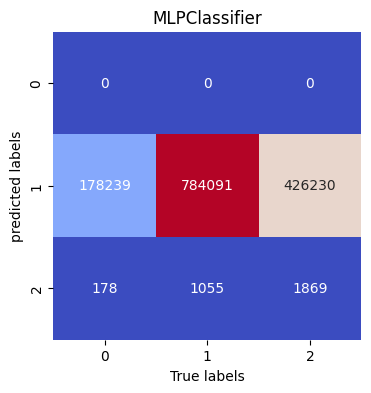

In [34]:
plot_cm(y_pred, y_test, "MLPClassifier", 'cm_MLPClassifie.pdf')

In [35]:
# Save the model
save_model(nn_model, "MLPClassifier")

Model size: 0.07 MB


# 6. Testing

In [36]:
model = joblib.load(r".\xgboost.joblib")

In [37]:
def boro (boro):
    if(boro == "BROOKLYN"):
        return 5
    if(boro == "STATEN ISLAND"):
        return 4
    if(boro == "BRONX"):
        return 3
    if (boro == "QUEENS"):
        return 2
    if (boro == "MANHATTAN"):
        return 1
    else :
        return 0

In [38]:
def race(r):
    if(r == "WHITE"):
        return 7
    if(r == "WHITE HISPANIC"):
        return 6
    if(r == "BLACK"):
        return 5
    if(r == "ASIAN / PACIFIC ISLANDER"):
        return 4
    if(r == "BLACK HISPANIC"):
        return 3
    if(r == "AMERICAN INDIAN/ALASKAN NATIVE"):
        return 2
    if(r == "OTHER"):
        return 1
    else :
        return 0

In [39]:
def sex(s):
    if(s == "F"):
        return 4
    if(s == "M"):
        return 3
    if(s == "D"):
        return 2
    if(s == "E"):
        return 1
    else : 
        return 0

In [40]:
import pandas as pd
def week_day(month, day, year):
    date=str(month)+"/"+str(day)+"/"+str(year)
    d = pd.Timestamp(date)
    day=d.day_name()
    return(day)

In [42]:
def create_df(hour,month,day,year,latitude,longitude,place,vic_age,vic_race,vic_sex):
    hour = int(hour) if int(hour) < 24 else 0
    api_data = None
    """try:
      api_data = requests.get(f'{api_endpoint}{longitude},{latitude}&distance=1000&token={api_token}').json()['address']
      pct, b = int(api_data["policePrecinct"]),api_data["Borough"]
      boro = boro.upper()
    except Exception as e:
       print(e)"""
    year = int(year)
    month = int(month)
    day = int(day)
    #dat = datetime(year=year, month=month, day=day)
    #weekday = dat.weekday() #Monday is 0 and Sunday is 6

    in_park = 1 if place == "In park" else 0
    in_public = 1 if place == "In public housing" else 0
    in_station = 1 if place == "In station" else 0
    vic_race = race(vic_race)
    vic_sex= sex(vic_sex)
    weekday= (week_day(month, day, year)).upper()
    

    columns = np.array(['IN_PARK', 'IN_PUBLIC_HOUSING', 'Latitude', 'Longitude', 'IN_STATION', 
                        'VIC_RACE', 'VIC_SEX', 'year', 'month', 'day', 'hour', 'VIC_AGE_GROUP_18-24', 'VIC_AGE_GROUP_25-44',
                        'VIC_AGE_GROUP_45-64', 'VIC_AGE_GROUP_65+', 'VIC_AGE_GROUP_-18', 'VIC_AGE_GROUP_UNKNOWN',
                        'weekday_Friday', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
                        'weekday_Tuesday', 'weekday_Wednesday'])
    
    data = [[in_park,
             in_public,
             latitude,
             longitude,
             in_station,
             vic_race,
             vic_sex,
             year, month, day,hour,
             1 if vic_age in range(18,25) else 0, 
             1 if vic_age in range(25,45) else 0, 
             1 if vic_age in range(45,65) else 0, 
             1 if vic_age>=65 else 0,
             1 if vic_age < 18 else 0,
             0,
             1 if weekday == "FRIDAY" else 0,
             1 if weekday == "MONDAY" else 0,
             1 if weekday == "SATURDAY" else 0,
             1 if weekday == "SUNDAY" else 0,
             1 if weekday == "THURSDAY" else 0,
             1 if weekday == "TUESDAY" else 0,
             1 if weekday == "WEDNESDAY" else 0,
             
       ]]

    df = pd.DataFrame(data,columns=columns)
    return df.values

In [43]:
#CRIME_CLASS	IN_PARK	IN_PUBLIC_HOUSING	Latitude	Longitude	IN_STATION	VIC_AGE_GROUP	VIC_RACE	VIC_SEX	year	month	day	hour	weekday
#2	            0	       0	           40.636991	-74.134093	    0        	45-64	       6         	4	2016	 10    	12  	7	Wednesday
#1              0	       0	           40.763992	-73.828426	    0	        25-44	       5	        3	2017	 5	    20	    4	Saturday

In [48]:
#hour,month,day,year,latitude,longitude,place,vic_age,vic_race,vic_sex
#data= create_df(7,10,12,2016,40.636991,-74.134093,'',50,"WHITE HISPANIC","F")
data= create_df(4,5,20,2017,40.763992,-73.828426,'',33,"BLACK","M")
data

array([[ 0.0000000e+00,  0.0000000e+00,  4.0763992e+01, -7.3828426e+01,
         0.0000000e+00,  5.0000000e+00,  3.0000000e+00,  2.0170000e+03,
         5.0000000e+00,  2.0000000e+01,  4.0000000e+00,  0.0000000e+00,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00]])

In [49]:
crime_types = {0:'Violation',1:"Misdemeanor",2:"Felony"}

In [50]:
def predict(data):
   pred = model.predict(data)[0]
   if (pred == 0):
      return crime_types[pred]
   elif pred==1:
      return crime_types[pred]
   else:
      return crime_types[pred]

In [51]:
pred = predict(data)
pred

'Misdemeanor'

In [52]:
pip install geoplot

     ---------------------------------------- 55.9/55.9 kB 2.9 MB/s eta 0:00:00
     -------------------------------------- 119.8/119.8 kB 1.2 MB/s eta 0:00:00
     -------------------------------------- 40.3/40.3 kB 477.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [53]:
pip install geopandas

In [54]:
import geoplot
import geopandas
boroughs = geopandas.read_file(geoplot.datasets.get_path('nyc_boroughs'))

In [55]:
boroughs

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330385.03697,1.623853e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,4,Queens,861038.47930,3.049947e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
2,3,Brooklyn,726568.94634,1.959432e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,1,Manhattan,358532.95642,6.364422e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,2,Bronx,464517.89055,1.186804e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
